In [146]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation as mad

In [147]:
def display_band( X, par,epsi=0.001,col='k'):
  x1 = np.min(X[0, :])
  x2 = np.max(X[0, :])
  y1 = np.min(X[1, :])
  y2 = np.max(X[1, :])

  # extend the line for the k# of its lenght 
  k = 0.01
  dx = x2-x1
  dy = y2-y1
  l = np.sqrt(dx**2+dy**2)
  x1 = x1 - k*l
  x2 = x2 + k*l
  y1 = y1 - k*l
  y2 = y2 + k*l
  ##
  if np.abs(par[1])<2e-2 :
      #disp('vertical line')
    a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
    b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
  else:
    a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
    b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

  if np.abs(par[0])<1e-5:
    v = np.array([0,1]) 
  else:    
    v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

  v = v / np.sqrt(np.sum(v**2))
  # corners of the bands
  v = v[:, np.newaxis]
  a1 = a - epsi * v
  a2 = a + epsi * v
  b1 = b - epsi * v
  b2 = b + epsi * v

  px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
  py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
  plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
  plt.gca().set_aspect('equal')

In [148]:
def res_line(X, M):
  if len(M.shape) > 1:
    num_lines = M.shape[1]
  else:
    num_lines = 1

  if num_lines == 1:
    d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
  else:
    n = X.shape[1]
    d = np.zeros((n, num_lines))
    for i in range(num_lines):
      d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])
  return d

In [149]:
def fit_line_ols(P):
  # design matrix
  x_col = P[:, 0]
  ones_col = np.ones_like(x_col)
  A = np.vstack([x_col, ones_col]).T
  # vector of responses 
  y = P[:, 1] 

  # straight line coefficient
  theta = np.linalg.inv(A.T @ A) @ A.T @ y

  residuals = y - A @ theta
  residual_error = np.sum(residuals ** 2)
  return theta, residuals, residual_error

In [150]:
def fit_line_dlt(P):
  
  mean_X = np.mean(P.T[:, 0])
  std_X = np.std(P.T[:, 0])
  
  mean_Y = np.mean(P.T[:, 1])
  std_Y = np.std(P.T[:, 1])
  
  X_normalized = (P.T[:, 0] - mean_X) / std_X
  Y_normalized = (P.T[:, 1] - mean_Y) / std_Y
  
  # design matrix
  A = np.hstack([X_normalized[:, np.newaxis], Y_normalized[:, np.newaxis], np.ones_like(X_normalized)[:, np.newaxis]])
  
  # SVD
  _,_, Vt = np.linalg.svd(A)
  
  theta = Vt[-1, :]
  
  theta[0]/=std_X
  theta[1]/=std_Y
  theta[2] -= (theta[0] * mean_X + theta[1] * mean_Y)
  
  theta /= (theta[0]**2 + theta[1]**2)**0.5
  
  residuals = res_line(P, theta) 
  residual_error = np.sum(residuals ** 2)
  
  return theta, residuals, residual_error


In [151]:
def simpleRANSAC(X, eps, cardmss = 2):
  """
  SIMPLERANSAC - Robust fit with the LMEDS algorithm
  X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
  """
  # number of samples in the dataset
  n = X.shape[1] 
  # Desired probability of success
  alpha = 0.99 

  # Pessimistic estimate of inliers fraction
  f = 0.5

  # set maximum number of iterations
  # use the reverse formula from probability 1-(1-(1-e)^s)^n = alpha
  MaxIterations = (np.log(1-alpha))/(np.log(1-(1-f)**cardmss))

  # set maximum consensus reached
  maxscore = -np.inf
 
  for i in range(int(MaxIterations)):
      
    # Generate cardmss random indices in the range 0..n-1
    mss_idx = np.random.choice(n, cardmss, replace=False)
    mss = X[:, mss_idx]
    
    # Fit model to this minimal sample set.
    theta,_,_ = fit_line_dlt(mss)

    # Evaluate distances between points and model
    sqres = res_line(X, theta)

    # identify inliers: consensus set
    inliers = np.where(sqres < eps)[0]

    # assess consensus (the number of inliers)
    score = len(inliers)

    # replace maxscore, bestinliers and bestmodel if needed
    if score > maxscore:
      maxscore = score
      bestinliers = inliers
      bestmodel = theta

  return bestmodel, bestinliers

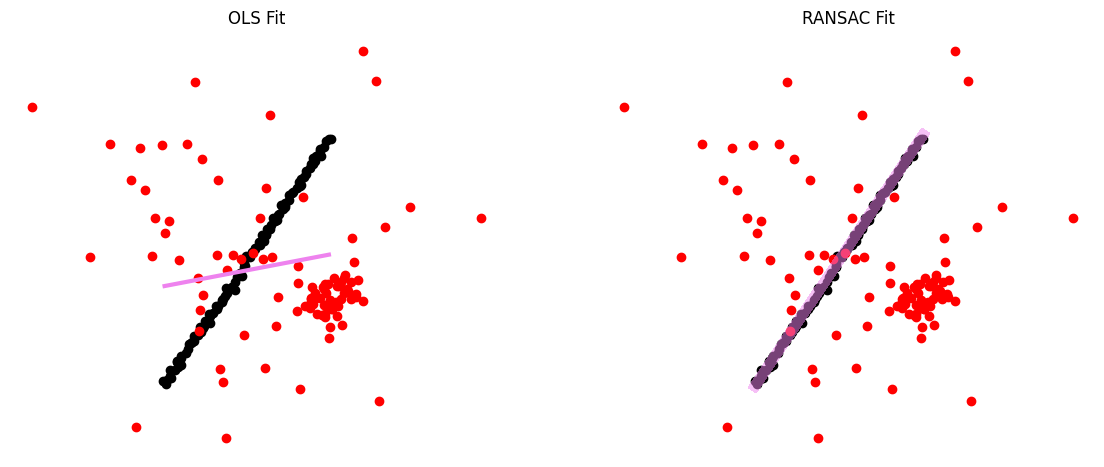

In [152]:
# create inlier dataset, slightly noisy
x = np.linspace(0,1,100)
y = 1.5 * x + 1
X = np.vstack((x, y))
sigma = 0.01
X = X + sigma * np.random.normal(size=X.shape)
X_out = X.copy()

# add gross outliers
n_out_gross = 50
out_gross_center = np.array([[1], [1.5]])
sigma_out_gross = 0.1
X_out_gross = np.random.normal(out_gross_center, sigma_out_gross, (2, n_out_gross))
X_out = np.hstack((X_out, X_out_gross))

# Add some noise
n_out_noise = 50
out_noise_center = np.array([[0.5], [1.75]])
sigma_out_noise = 0.5
X_out_noise = np.random.normal(out_noise_center, sigma_out_noise, (2, n_out_noise))
X_out = np.hstack((X_out, X_out_noise))

# --- FIT LINES ---

# OLS
model_OLS = fit_line_ols(X_out.T)[0]

# RANSAC
epsi = 3 * sigma # define inlier threshold
bestmodel, bestinliers = simpleRANSAC(X_out, epsi)
refinedModel = fit_line_dlt(X_out[:, bestinliers])[0]

# --- PLOTTING ---
BAND_WIDTH = 0.05
BAND_COLOR = 'violet'
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Define limits to "cut" the view
x_limits = (-2, 2)  # Adjust these as needed to center on the inliers
y_limits = (-2, 2)  # Adjust these as needed

# First subplot: OLS
axs[0].scatter(X[0, :], X[1, :], c='black')
axs[0].scatter(X_out_gross[0, :], X_out_gross[1, :], c='red')
axs[0].scatter(X_out_noise[0, :], X_out_noise[1, :], c='red')
axs[0].plot([0, 1], [model_OLS[1], model_OLS[0] + model_OLS[1]], 'violet', linewidth=3)
axs[0].set_title('OLS Fit')
axs[0].axis('off')
axs[0].set_aspect('equal')

# Second subplot: RANSAC
axs[1].scatter(X[0, :], X[1, :], c='black')
axs[1].scatter(X_out_gross[0, :], X_out_gross[1, :], c='red')
axs[1].scatter(X_out_noise[0, :], X_out_noise[1, :], c='red')
display_band(X, refinedModel, epsi, BAND_COLOR)
axs[1].set_title('RANSAC Fit')
axs[1].axis('off')
axs[1].set_aspect('equal')

plt.show()
